<a href="https://colab.research.google.com/github/pedro-de-bastos/Practical-Data-Science-IL181/blob/master/Codebook_IL181_Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Codebook: Predicting House Prices PCA, TSNE, and XGBoost

By: Pedro Martins de Bastos


# Table of Contents


1.   Introduction
2.   Importing the Required Libraries and Data
3.   Data Preprocessing
4.   PCA Decomposition
5.   TSNE Decomposition
6.   XGBoost
  - Training the Model 
  - Bayesian Optimization
  - XGBoost Visual: Relative Importance



# Introduction

This project consists of applying different techniques with the purpose of predicting the prices of houses in Ames, Iowa, based on a dataset from a [Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). We start by cleaning up the data, and then move on to implement Principle Component Analysis, TSNE, and finally, we use the XGBoost algorithm to predict the prices of houses.

# Importing the Required Libraries and Data
The first step here is to make sure that the libraries and we need are imported:

In [ ]:
#Import Libraries 

import re
import pandas as pd
from matplotlib import pyplot
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set()
%matplotlib inline

In [ ]:
#Import Data
df_train = pd.read_csv('/content/drive/MyDrive/IL181 - Practical Data Science/IL181 Individual Project/House_Prices/train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/IL181 - Practical Data Science/IL181 Individual Project/House_Prices/test.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing
Now, we perform one of the most important steps in data science: preprocessing the data before our algorithms can do the required work.


In [ ]:
#Deleting columns with many missing data points, determined by the df_train.describe() command for each of these columns (which shows us how many values are missing)
df_train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','LotFrontage'], axis = 1,inplace=True)

#Drop rows with missing data, to make sure there are no problems for the algorithms
df_train.dropna(inplace=True)
df_train.shape

(1338, 75)

In [ ]:
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

Next, we come to an unfortunate conlusion about the data provided by Kaggle: although they provide participants with test and train data, we don't have the y values (the prices of the houses) for the test set (after all, it is a competition to see who gets these values right), therefore we have to make do with splitting the original train dataset into a subtest and subtrain sets (from here on out, I refer to these subtrain and subtest sets simply as train and test sets).

Also note that some of the columns encode categorical variables, like street names, and for those to be parsed by our algorithms, we require them to be encoded properly as numbers. The pd.get_dummies command accomplishes that nicely by creating new columns that encode these categorical variables as dummy variables.

In [ ]:
from sklearn.model_selection import train_test_split
df_train = pd.get_dummies(df_train)
X_train, X_test, y_train, y_test = train_test_split(df_train.loc[:, df_train.columns != 'SalePrice'], df_train['SalePrice'], test_size=0.25, random_state=42)

# PCA Decomposition
Now, we will be will be performing principle commponent analysis on the data to reduce its countless dimensions, and also to visualize how each component of the PCA breakdown explains the data. One of the benefits of PCA is that, by reducing the number of dimensions from around 200 to 10, we can more easily visualize the data. Taking the two most improtant components of PCA allows us to plot the data in 2d! I decided to plot the data in 2d, and add a further dimension by coloring in each datum (representing each house in our dataset) according to how much each house cost. To do this, I had to first encode the prices of these houses into different color categories, which I do below:

In [ ]:
#Creating Price Categories for TSNE and PCA Visualization!! We may want to use
#this in training classification models as well
def what_bracket(sale_price):
  if sale_price <=100000:
    return "Tier 1"
  elif sale_price <=200000:
    return "Tier 2"
  elif sale_price <=300000:
    return "Tier 3"
  elif sale_price <= 500000:
    return "Tier 4"
  else:
    return "Tier 5"

y_tiers = y_train.apply(what_bracket) #Creating the categories

In [ ]:
#Here I decompose each image into 50 principal components
from sklearn.decomposition import PCA

def pca_dec(data, n):
  pca = PCA(n)
  X_dec = pca.fit_transform(data)
  return X_dec, pca

#Decomposing the train set:
pca_train_results, pca_train = pca_dec(X_train, 10)

#Decomposing the test set:
pca_test_results, pca_test = pca_dec(X_test, 10)

#Creating a table with the explained variance ratio
names_pcas = [f"PCA Component {i}" for i in range(1, 11, 1)]
scree = pd.DataFrame(list(zip(names_pcas, pca_train.explained_variance_ratio_)), columns=["Component", "Explained Variance Ratio"])
print(scree)

          Component  Explained Variance Ratio
0   PCA Component 1                  0.985988
1   PCA Component 2                  0.004436
2   PCA Component 3                  0.003187
3   PCA Component 4                  0.002591
4   PCA Component 5                  0.001587
5   PCA Component 6                  0.000903
6   PCA Component 7                  0.000401
7   PCA Component 8                  0.000240
8   PCA Component 9                  0.000189
9  PCA Component 10                  0.000181


The table above shows us exactly how "important" each principle component is in explaining the data. Clearly, the first component is considerably more important than the remaining 9. We can visualize how steep the difference is in the graph below:

Text(0, 0.5, 'Explained Variance Ratio')

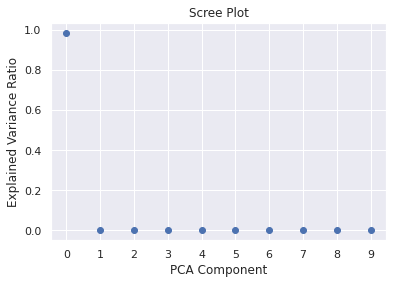

In [ ]:
#Creating a scree plot:
xs = np.linspace(0, 9, 10)

plt.scatter(xs, pca_train.explained_variance_ratio_)
plt.title("Scree Plot")
plt.xlabel("PCA Component")
plt.xticks(ticks=xs)
plt.ylabel("Explained Variance Ratio")

Now that we know that the first two principle components (and indeed the first principle component alone) explain a huge portion of the variance, we can say that using these two components to represent the data is reasonable. I therefore plot each house datum according to these two components, below:

Text(0, 0.5, 'PCA Component 2')

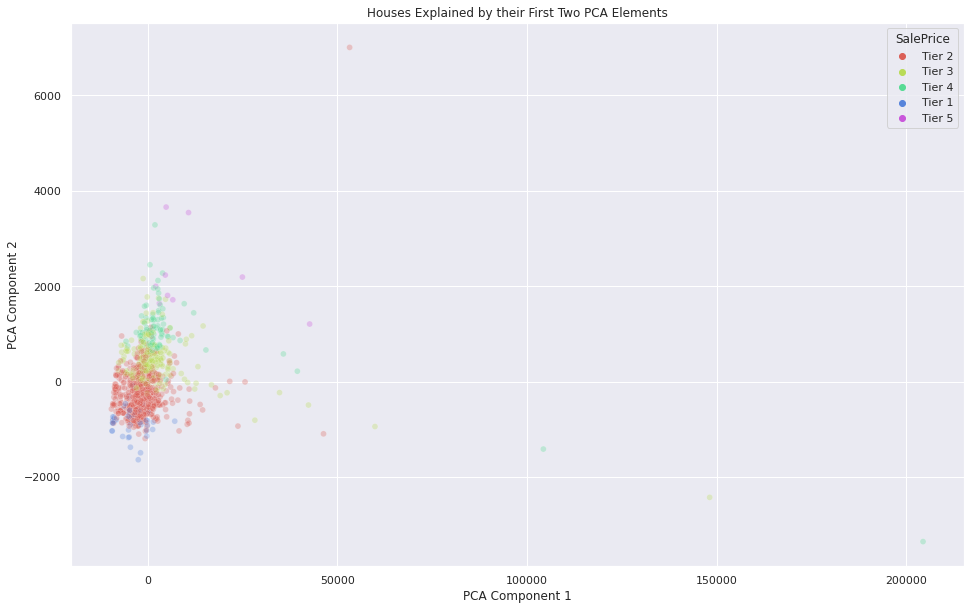

In [ ]:
#Plotting the first two PCA components, as well as the price tier of the house
#to see if PCA helps us distinguish price-points

import seaborn as sns
import matplotlib.pyplot as plt

first_comps = pca_train_results[:,0] #Taking the first PCA component for each
                                    #decomposed house's data

second_comps = pca_train_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=first_comps, y=second_comps,
    hue=y_tiers,
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=0.3
)

plt.title("Houses Explained by their First Two PCA Elements")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")


## Looking Closely at the First Principal Component
What is the composition of the first principal component, that seems to be so important? Knowing this can give us insight into the problem of determining the prices of these houses:

In [ ]:
#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[0], 'Variable Names':list(X_train.columns)})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
print(df2['Variable Names'][0:11])

2         LotArea
15      GrLivArea
12       1stFlrSF
11    TotalBsmtSF
8      BsmtFinSF1
26     GarageArea
9      BsmtFinSF2
7      MasVnrArea
13       2ndFlrSF
27     WoodDeckSF
0              Id
Name: Variable Names, dtype: object


In [ ]:
df.head()

,PCA,Variable Names
2,0.999730,LotArea
15,0.013377,GrLivArea
12,0.011297,1stFlrSF
11,0.010933,TotalBsmtSF
8,0.009208,BsmtFinSF1


The variables printed above are the largest contributors to the first principal components, and thus can be seen as the variables that best explain the variance in the data. Lot Area in particular has a very high influence, at 99.9%. The second most influential variable is Ground Living Area, how much area there is above ground, which is at around 1.2%. Furthermore, note that the first principal component corresponds to 99% of the variance of the data, and therefore that Lot Area is by far the most important variable in determining the variance. This makes a lot of sense intuitively: larger lot areas mean more space for all other factors like pools, garages, rooms, basements, etc.

## Looking Closely at the Second Principal Component
How about the second principal component? What does it show us?

In [ ]:
#Sorting the values of the first principal component by how large each one is
df = pd.DataFrame({'PCA':pca_train.components_[1], 'Variable Names':list(X_train.columns)})
df = df.sort_values('PCA', ascending=False)

#Sorting the absolute values of the first principal component by magnitude
df2 = pd.DataFrame(df)
df2['PCA']=df2['PCA'].apply(np.absolute)
df2 = df2.sort_values('PCA', ascending=False)
print(df2['Variable Names'][0:11])

15      GrLivArea
11    TotalBsmtSF
12       1stFlrSF
8      BsmtFinSF1
13       2ndFlrSF
10      BsmtUnfSF
26     GarageArea
7      MasVnrArea
27     WoodDeckSF
28    OpenPorchSF
2         LotArea
Name: Variable Names, dtype: object


In [ ]:
df.head()

,PCA,Variable Names
15,0.636707,GrLivArea
11,0.452011,TotalBsmtSF
12,0.437619,1stFlrSF
8,0.274906,BsmtFinSF1
13,0.197455,2ndFlrSF


We can see that, now that the first component has accounted for the importance of living area, other components like ground living area had total basement area look to be given more importance.

# TSNE Decomposition
TSNE is another dimensionality reduction technique that reduces a multidimensional datum into only two dimensions. It is more time costly than PCA, but gives us great results, and makes it super easy to visualize the data. I repeat most of the steps I did for PCA in order to produce a graph that shows us how the data is graphed according to TSNE.

In [ ]:
from sklearn.manifold import TSNE

#Decomposing the data with TSNE, onto 2 dimensions
tsne_train = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_train_results = tsne_train.fit_transform(X_train)

tsne_test = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
tsne_test_results = tsne_test.fit_transform(X_test)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1003 samples in 0.022s...
[t-SNE] Computed neighbors for 1003 samples in 0.286s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1003
[t-SNE] Computed conditional probabilities for sample 1003 / 1003
[t-SNE] Mean sigma: 351.770277
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.825787
[t-SNE] KL divergence after 500 iterations: 0.698416
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 335 samples in 0.005s...
[t-SNE] Computed neighbors for 335 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 335 / 335
[t-SNE] Mean sigma: 413.314007
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.314491
[t-SNE] KL divergence after 500 iterations: 0.390121


Text(0.5, 1.0, 'T-SNE Decomposed Data')

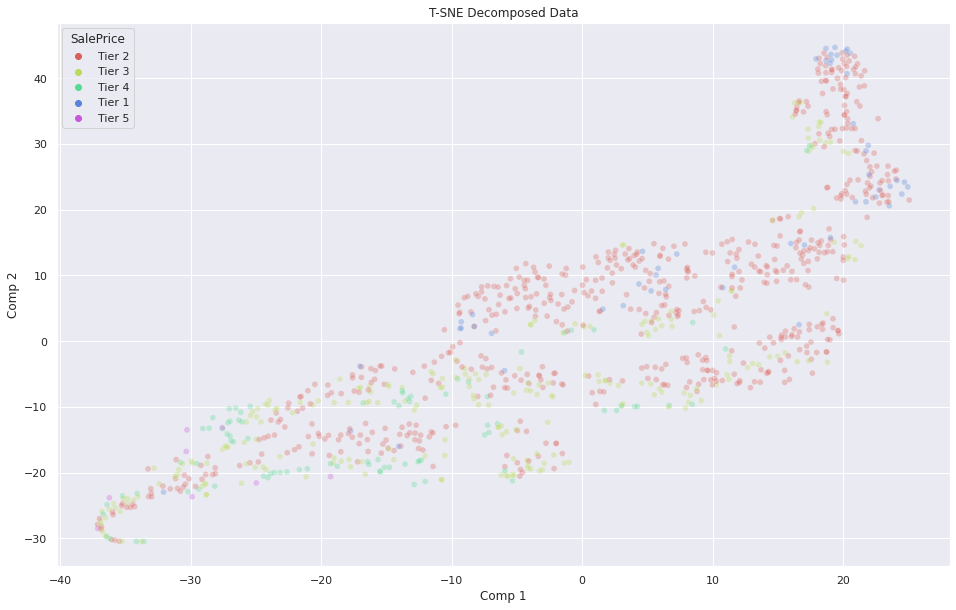

In [ ]:
#Plotting the data as explained by the two TSNE components
first_tsne = tsne_train_results[:,0]
second_tsne = tsne_train_results[:,1]

import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(16,10))
sns.scatterplot(
    x=first_tsne, y=second_tsne,
    hue=y_tiers,
    palette=sns.color_palette("hls", 5),
    legend="full",
    alpha=0.3
)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("T-SNE Decomposed Data")

This graph makes it easier to identify each datum, but it doesn't necessarily help us find clusters according to price (color). If we could see clear clusters, that would be good news for prediction algorithms trying to determine how price changes.

# XGBOOST
We've now investigated how the data looks after dimensionality reduction, and that in itself has given us insight into the data and what seem to be important explainers of variance, altough not necessarily of price. Now we use XGboost, a state-of-the-art algorithm, to regress the predictor variables against the prices of the houses, thereby predicting how much a house should cost based on these variables.

## Training the Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#The xgboost library has a data object that is optimized for this library specifically, and I therefore convert our existing data to the Xgboost-prefered datamatrix format:
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

#I set the hyperparameters of our xgboost algorithm to relatively random variables to start with, based on recommendations within the documentation:
params = {"objective":'reg:squarederror', "colsample_bytree":0.5, "learning_rate":0.2, "max_depth":10, "alpha":20}

#Lets train the model!
xg_m = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50)

#Now we can test the trained model by first formatting the test data
data_dmatrix_test = xgb.DMatrix(data=X_test)

#And now we predict the prices for the test data
preds = xg_m.predict(data_dmatrix_test)

#How well did we do? A standard measure of performance is the RMSE, the root mean square error, calculated as such:
RMSE = np.sqrt(mean_squared_error(preds, y_test))
print(RMSE)

#Whatever our performance, we can expect to be able to improve it by tinkering with the hyperparameters. To do hyperparameter optimization, we will also do k-fold cross validation. The k-fold will prevent us from overfitting to the train set: we can use the RMSE of the cross validation as a variable to be optimized, and the hyperparameters as the input variables we change:

def fcv(max_depth, gamma, min_child_weight, subsample, colsample_bytree, learning_rate, num_boost_round):
  params = {"objective":'reg:squarederror', "max_depth":int(max_depth), 'gamma':gamma, 'min_child_weight':min_child_weight, 'subsample':subsample, "colsample_bytree":colsample_bytree, "learning_rate":learning_rate}
  cv_results=xgb.cv(dtrain=data_dmatrix, params=params, nfold=10, num_boost_round=int(num_boost_round), early_stopping_rounds=10, metrics='rmse', as_pandas=True)
  return -cv_results['test-rmse-mean'].min() #any idea why I used a negative sign? Hint: it matters for the Bayesian Optimization function?


33799.36647975169


In [ ]:
np.std(y_train)

83079.35085062851

What does our RMSE mean? Is it good or bad in absolute terms? One way to get a sense is to compare the RMSE to the standard deviation of our data. The standard deviation tells us by how much most data deviate from the mean, and so knowing how wrong we are getting predictions based on that value gives us a sense of how big that error is relative to this dataset.

Another way to tell how well we may be doing is to visualize the predictions compared to the real data: the graph below plots the predictions (in blue) and the real values (in red):

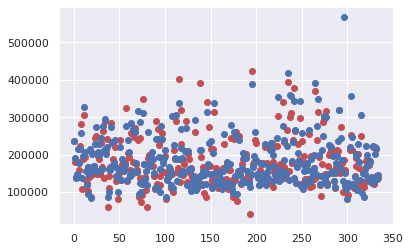

In [ ]:
x = range(335)
plt.plot(x, y_test, 'ro')
plt.plot(x, preds, 'bo')

## Bayesian Optimization

It seems like we did a good job, but we can certainly improve! Let us now tinker with one of the hyperparameters: the learnning rate. The learning rate describes how big an adjustment xgboost makes each time it improves its trees: it goes from 0 (very small change) to 1 (very intense changes). Lets use the cross validation function, f(x), to change only the learning rate and leave the other hyperparameters as they were:

In [ ]:
x = np.linspace(0, 0.6, num=20)

lst=[]
for i in x:
  lst.append(fcv(2, 2, 0.2, i, 0.2, 16, 70))

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0.5, 1.0, 'How does RMSE change with inceasing Learning Rate?')

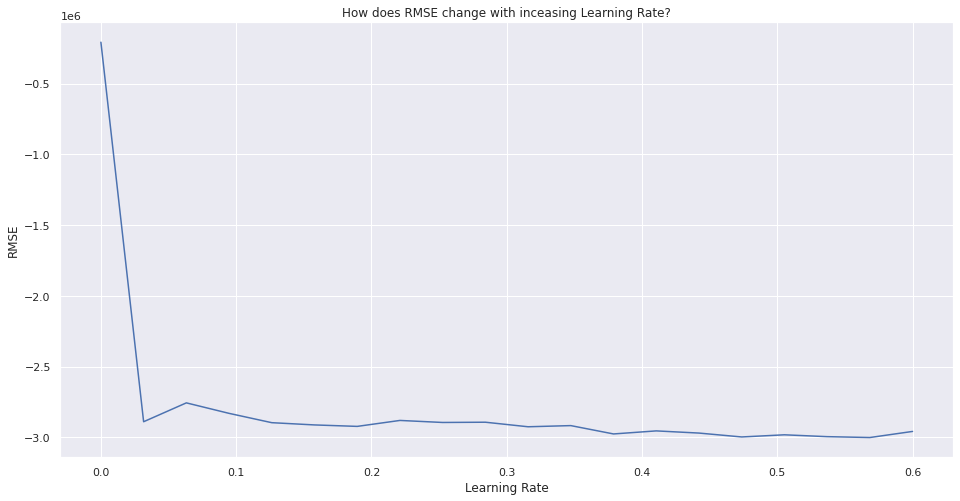

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(x, lst)
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.title("How does RMSE change with inceasing Learning Rate?")

It seems like after increasing the learning rate up to around 0.08 or so we have diminishing returns in terms of reducing RMSE! In fact, it seems that for around 0.6 RMSE starts to go up again (which makes sense: learning steps start to become too big).

The big problem here is that we are keeping all the other hyperparameters constant: we don't know how the learning rate can interact with them! Perhaps it is the case that for another value of the number of trees being build, for instance, the optimal learning rate changes as well. Because there are so many hyperparameters, it becomes quite difficult to perform an extensive search through all possibilities, and we instead should use something a little smarter: Bayesian optimization.

Bayesian optimization makes use of Gaussian processes to come up with tentative combinations of our hyperparameters that have the highest probability to be improvements. It experiments along the search space, taking in consideration past 'mistakes' in order to becocme ever better at guessing good hyperparameters. The BayesianOptimization library in Python implements this algorithm for us, so we just have to define what our hyperparameters are, and the bounds within which we want BayesianOptimization to search for each hyperparameter:

In [ ]:
#!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=881399968f202626163d6cd0a171daa657427c395d837e6fbf371737b7c4e0ba
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

#Now, create a dictionary for the boundaries we should search within, and call
#the bayesian optimization function!
dict_cv = {
          'max_depth': (2, 12),
          'gamma': (0.001, 10.0),
          'min_child_weight': (0, 20),
          'subsample': (0.4, 1.0),
          'colsample_bytree': (0.4, 1.0),
          'learning_rate': (0.1, 1.0),
          'num_boost_round' :(30, 100)
          }



XGB_BO = BayesianOptimization(fcv, dict_cv) #Creating the optimizer
XGB_BO.maximize(init_points=10, n_iter=40, acq='ei', xi=0.0) #Running optimization!

With the optimized set of hyperparameters in hand, we can now train our model again, using those hyperparameters, and see our performance improvements:

In [ ]:
params = XGB_BO.max['params']
params['max_depth'] = int(params['max_depth'])

xg_m = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=int(params['num_boost_round']))

#Now we can test the trained model by first formatting the test data
data_dmatrix_test = xgb.DMatrix(data=X_test)

#And now we predict the prices for the test data
preds = xg_m.predict(data_dmatrix_test)

#How well did we do? A standard measure of performance is the RMSE, the root mean square error, calculated as such:
RMSE = np.sqrt(mean_squared_error(preds, y_test))
print(RMSE)

32895.06455762572


Seems like we got a modest but real improvement for the RMSE! If we keep running the Bayesian Optimization for longer and longer rounds, it is likely that we will find even better sets of hyperparameters.

## XGBoost Visual: Relative Importance
XGBoost is a great algorithm for many reasons: it is accurate, fast, and easy to interpret. This final advantage comes from the fact that XGBoost is building decision trees, which are fairly easy for us to comprehend. The XGBoost library allows us to investigate which factors were most important in our regressions, i.e. what were the best predictors of house prices. I plot that graph for our optimized model below:

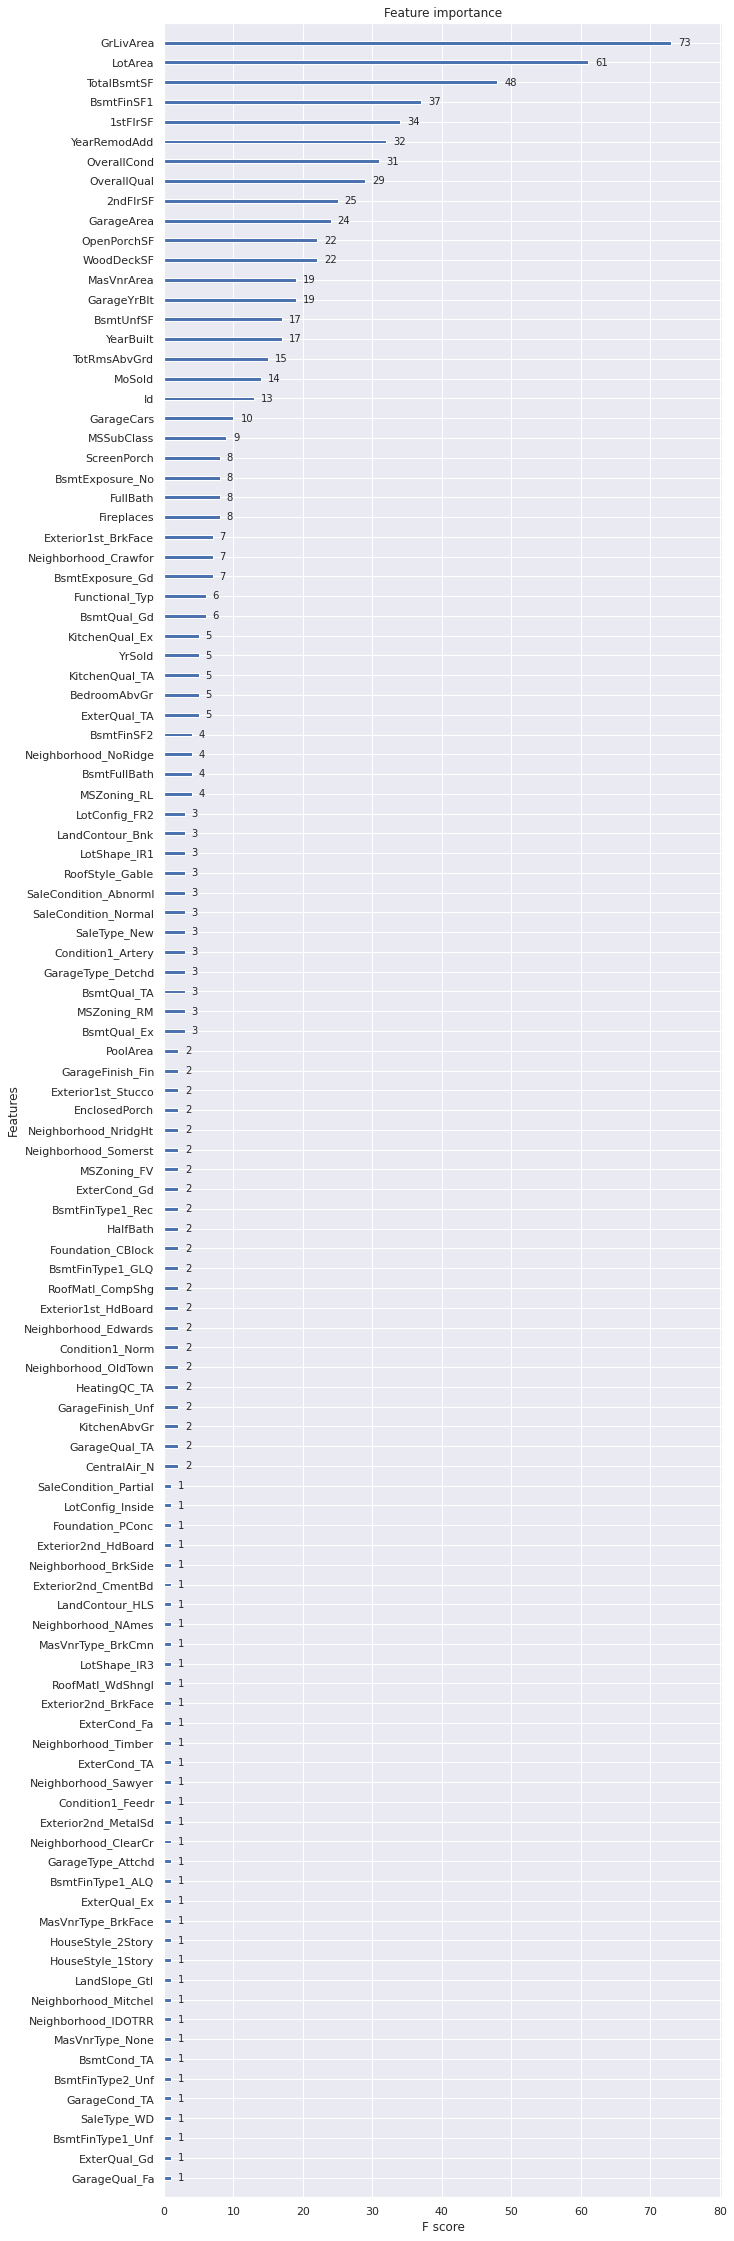

In [ ]:
xgb.plot_importance(xg_m)
plt.rcParams['figure.figsize'] = [10, 40]
plt.show()